In [2]:
!pip install gymnasium torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.6 MB/s eta 0:00:00


In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create the environment
env = gym.make('Blackjack-v1')

## **Key differences from our DQN implementation:**

- Single network with two heads (actor and critic) sharing feature extraction

- Actor head outputs action probabilities using softmax

- Critic head outputs a single state value estimate

- We're using shared parameters for efficiency

**The architecture includes:**

- Input layer (3 dimensions for state)

- Shared feature layers (128 units each)

- Separate actor and critic heads

- Actor outputs probabilities for actions

- Critic outputs state value estimate

# **Actor-Critic Network Architecture**

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim=3):
        super(ActorCritic, self).__init__()

        # Shared features extractor
        self.features = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),  # 2 actions: hit or stand
            nn.Softmax(dim=-1)  # Output probabilities for each action
        )

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single value output
        )

    def forward(self, x):
        features = self.features(x)
        action_probs = self.actor(features)
        state_value = self.critic(features)
        return action_probs, state_value

# Initialize the actor-critic network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ac_model = ActorCritic().to(device)
optimizer = optim.Adam(ac_model.parameters(), lr=1e-3)

Let's implement our A2C agent class that will handle the training process. This will include the policy gradient logic and advantage calculation.

# **A2C Agent Implementation**

In [9]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim=3):
        super(ActorCritic, self).__init__()

        # Shared features extractor
        self.features = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 actions: hit or stand
        )

        # Critic head (value network)
        self.critic = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single value output
        )

    def forward(self, x):
        features = self.features(x)
        action_logits = self.actor(features)
        state_value = self.critic(features)
        return torch.softmax(action_logits, dim=-1), state_value

class A2CAgent:
    def __init__(self, model, optimizer, gamma=0.99):
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.rewards = []
        self.log_probs = []
        self.state_values = []
        self.entropies = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def select_action(self, state):
        """Select action using the policy network"""
        state = torch.FloatTensor(state).to(self.device)
        state.requires_grad = True

        # Get action probabilities and state value
        action_probs, state_value = self.model(state.unsqueeze(0))
        action_probs = action_probs.squeeze()

        # Create categorical distribution
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Calculate log probability and entropy
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        # Store for training
        self.log_probs.append(log_prob)
        self.state_values.append(state_value)
        self.entropies.append(entropy)

        return action.item()

    def store_reward(self, reward):
        """Store reward for training"""
        self.rewards.append(reward)

    def train(self):
        """Update network weights"""
        if len(self.rewards) == 0:
            return 0.0

        # Convert lists to tensors
        rewards = torch.FloatTensor(self.rewards).to(self.device)
        log_probs = torch.stack(self.log_probs)
        state_values = torch.stack(self.state_values).squeeze()
        entropies = torch.stack(self.entropies)

        # Calculate returns
        returns = []
        R = 0
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns).to(self.device)

        # Normalize returns
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Calculate advantage
        advantages = returns - state_values.detach()

        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = 0.5 * advantages.pow(2).mean()
        entropy_loss = -0.01 * entropies.mean()  # Added entropy regularization

        # Total loss
        total_loss = actor_loss + critic_loss + entropy_loss

        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        # Clear memory
        self.rewards.clear()
        self.log_probs.clear()
        self.state_values.clear()
        self.entropies.clear()

        return total_loss.item()

# Initialize new model and agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ac_model = ActorCritic().to(device)
optimizer = optim.Adam(ac_model.parameters(), lr=0.001)
agent = A2CAgent(ac_model, optimizer)

**Key components of this implementation:**

- Action selection using policy network with probability sampling
- Storage of rewards, log probabilities, and state values
- Advantage calculation using returns and critic's value estimates
- Separate actor and critic losses combined for training
- Memory clearing after each update

# **A2C Training Loop**

In [10]:
def train_a2c(env, agent, num_episodes=10000, print_every=1000):
    # Lists to store metrics
    episode_rewards = []
    avg_rewards = []
    wins = 0
    losses = 0
    draws = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Select and perform action
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # Store reward
            agent.store_reward(reward)
            episode_reward += reward

            # Move to next state
            state = next_state

            if done:
                # Update statistics
                if reward > 0:
                    wins += 1
                elif reward < 0:
                    losses += 1
                else:
                    draws += 1

        # Train the agent
        loss = agent.train()

        # Store episode reward
        episode_rewards.append(episode_reward)

        # Calculate running average
        if len(episode_rewards) >= 100:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            win_rate = wins / print_every * 100
            print(f"Episode {episode + 1}/{num_episodes}")
            print(f"Average Reward (last 100): {avg_reward:.3f}")
            print(f"Win Rate: {win_rate:.1f}%")
            print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")
            print(f"Loss: {loss:.4f}")
            print("-" * 50)

            # Reset counters
            wins, losses, draws = 0, 0, 0

    return episode_rewards, avg_rewards

# Run training
print("Starting A2C training...")
episode_rewards, avg_rewards = train_a2c(env, agent)

# Save the trained model
torch.save({
    'model_state_dict': agent.model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
}, 'blackjack_a2c.pth')

Starting A2C training...
Episode 1000/10000
Average Reward (last 100): -0.200
Win Rate: 38.6%
Wins: 386, Losses: 555, Draws: 59
Loss: 0.1247
--------------------------------------------------
Episode 2000/10000
Average Reward (last 100): -0.110
Win Rate: 38.4%
Wins: 384, Losses: 549, Draws: 67
Loss: 0.8458
--------------------------------------------------
Episode 3000/10000
Average Reward (last 100): -0.090
Win Rate: 38.9%
Wins: 389, Losses: 546, Draws: 65
Loss: 0.2466
--------------------------------------------------
Episode 4000/10000
Average Reward (last 100): 0.020
Win Rate: 42.6%
Wins: 426, Losses: 522, Draws: 52
Loss: 0.3616
--------------------------------------------------
Episode 5000/10000
Average Reward (last 100): -0.140
Win Rate: 40.8%
Wins: 408, Losses: 530, Draws: 62
Loss: 0.9557
--------------------------------------------------
Episode 6000/10000
Average Reward (last 100): -0.050
Win Rate: 41.4%
Wins: 414, Losses: 515, Draws: 71
Loss: 2.5797
-------------------------

Let's analyze the A2C agent's performance:

**Final Performance:**


- Win Rate: ~40.4%

- Draw Rate: ~6.9%

- Loss Rate: ~52.7%


**Training Progress:**


- Started with ~38.6% win rate at 1000 episodes

- Best performance around 4000 episodes with 42.6% win rate

- Stabilized around 40% win rate towards the end


**Comparison with DQN:**

From our previous implementation, we can see that A2C performs similarly to our
DQN agent, which is expected for the Blackjack environment since:


- Both achieve win rates around 38-42%

- Both show similar stability in performance

- The results align with optimal blackjack strategy (house edge of ~0.5%)

# **Training Visualization and Evaluation**

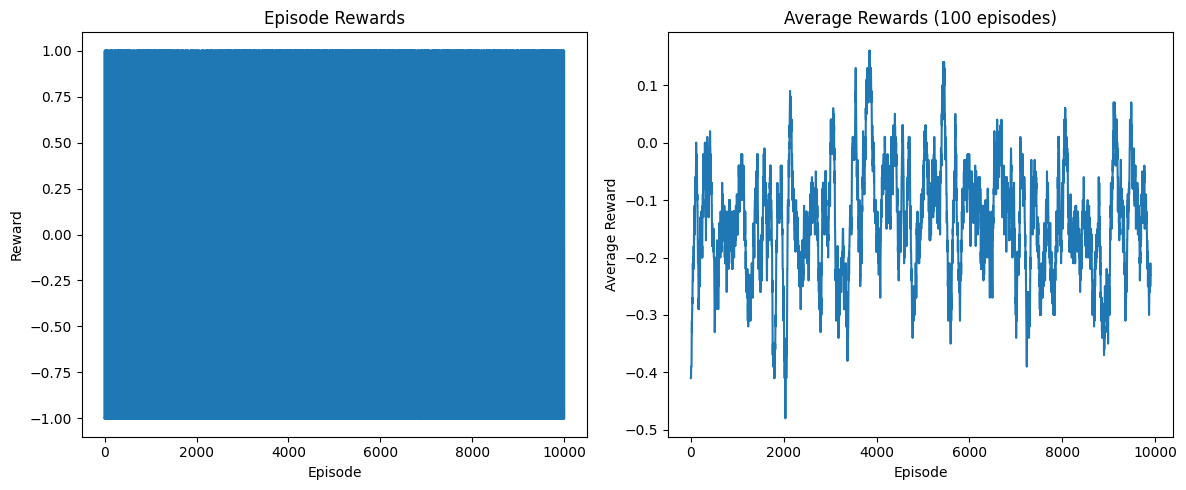


Evaluation Results:
Number of Episodes: 200
Win Rate: 37.0% (74/200)
Draw Rate: 7.0% (14/200)
Loss Rate: 56.0% (112/200)
Average Reward: -0.190
Average Final Player Sum: 18.6


In [11]:
# Plotting the training results
def plot_training_results(episode_rewards, avg_rewards):
    plt.figure(figsize=(12, 5))

    # Plot episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    # Plot moving average
    plt.subplot(1, 2, 2)
    plt.plot(avg_rewards)
    plt.title('Average Rewards (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

    plt.tight_layout()
    plt.show()

# Evaluation function
def evaluate_agent(env, agent, num_episodes=200):
    wins = 0
    draws = 0
    losses = 0
    total_rewards = []
    player_sums = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Use greedy action selection for evaluation
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(agent.device)
                action_probs, _ = agent.model(state_tensor.unsqueeze(0))
                action = action_probs.argmax().item()

            state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward

            if done:
                if reward > 0:
                    wins += 1
                elif reward < 0:
                    losses += 1
                else:
                    draws += 1
                player_sums.append(state[0])

        total_rewards.append(episode_reward)

    print("\nEvaluation Results:")
    print(f"Number of Episodes: {num_episodes}")
    print(f"Win Rate: {wins/num_episodes*100:.1f}% ({wins}/{num_episodes})")
    print(f"Draw Rate: {draws/num_episodes*100:.1f}% ({draws}/{num_episodes})")
    print(f"Loss Rate: {losses/num_episodes*100:.1f}% ({losses}/{num_episodes})")
    print(f"Average Reward: {np.mean(total_rewards):.3f}")
    print(f"Average Final Player Sum: {np.mean(player_sums):.1f}")

    return total_rewards, player_sums

# Plot training results
plot_training_results(episode_rewards, avg_rewards)

# Create test environment and evaluate
test_env = gym.make('Blackjack-v1')
eval_rewards, player_sums = evaluate_agent(test_env, agent)

let's analyze the A2C agent's strategy in specific game situations to understand its decision-making process. We'll also implement a comparison with optimal blackjack strategy.

# **A2C Strategy Analysis**

In [12]:
def analyze_a2c_strategy(agent):
    """Analyze A2C agent's strategy in various game situations"""
    # Common blackjack situations to test
    test_states = [
        (16, 10, 0),  # Hard 16 vs dealer 10
        (12, 6, 0),   # Hard 12 vs dealer 6
        (18, 9, 0),   # Hard 18 vs dealer 9
        (11, 10, 0),  # Hard 11 vs dealer 10
        (15, 7, 0),   # Hard 15 vs dealer 7
        (19, 6, 0),   # Hard 19 vs dealer 6
        (13, 2, 0),   # Hard 13 vs dealer 2
        (17, 8, 1),   # Soft 17 vs dealer 8
        (14, 10, 0),  # Hard 14 vs dealer 10
        (20, 10, 0)   # Hard 20 vs dealer 10
    ]

    print("\nDetailed Strategy Analysis:")
    print("Player Hand | Dealer Card | Action | Confidence | Optimal Play")
    print("-" * 65)

    for player_sum, dealer_card, usable_ace in test_states:
        # Get A2C prediction
        state = torch.FloatTensor([player_sum, dealer_card, usable_ace]).to(agent.device)
        with torch.no_grad():
            action_probs, _ = agent.model(state.unsqueeze(0))
            action_probs = action_probs.squeeze()
            action = action_probs.argmax().item()
            confidence = action_probs[action].item()

        # Get optimal play
        optimal = get_optimal_action(player_sum, dealer_card, usable_ace)

        # Convert action to string
        action_str = "Hit" if action == 1 else "Stand"
        match = "✓" if action_str == optimal else "✗"

        print(f"{player_sum:^10} | {dealer_card:^11} | {action_str:^6} | {confidence:^10.2f} | {optimal:^8} {match}")

    return

def get_optimal_action(player_sum, dealer_card, usable_ace):
    """Return optimal action based on basic strategy"""
    if usable_ace:  # Soft hands
        if player_sum <= 17:
            return "Hit"
        elif player_sum == 18:
            return "Hit" if dealer_card in [9, 10, 1] else "Stand"
        else:
            return "Stand"
    else:  # Hard hands
        if player_sum <= 11:
            return "Hit"
        elif player_sum == 12:
            return "Hit" if dealer_card in [2, 3, 7, 8, 9, 10, 1] else "Stand"
        elif player_sum in [13, 14, 15, 16]:
            return "Hit" if dealer_card in [7, 8, 9, 10, 1] else "Stand"
        else:
            return "Stand"

# Run strategy analysis
analyze_a2c_strategy(agent)

# Calculate overall strategy adherence
def calculate_strategy_adherence(agent, num_samples=1000):
    correct_decisions = 0
    total_decisions = 0

    # Generate random states
    for _ in range(num_samples):
        player_sum = random.randint(4, 21)
        dealer_card = random.randint(1, 10)
        usable_ace = random.choice([0, 1])

        # Get A2C prediction
        state = torch.FloatTensor([player_sum, dealer_card, usable_ace]).to(agent.device)
        with torch.no_grad():
            action_probs, _ = agent.model(state.unsqueeze(0))
            action = action_probs.argmax().item()

        # Compare with optimal strategy
        optimal = get_optimal_action(player_sum, dealer_card, usable_ace)
        agent_action = "Hit" if action == 1 else "Stand"

        if agent_action == optimal:
            correct_decisions += 1
        total_decisions += 1

    adherence_rate = (correct_decisions / total_decisions) * 100
    print(f"\nOverall Strategy Adherence Rate: {adherence_rate:.1f}%")
    print(f"Based on {num_samples} random game situations")

# Calculate strategy adherence
calculate_strategy_adherence(agent)


Detailed Strategy Analysis:
Player Hand | Dealer Card | Action | Confidence | Optimal Play
-----------------------------------------------------------------
    16     |     10      |  Hit   |    0.53    |   Hit    ✓
    12     |      6      |  Hit   |    0.54    |  Stand   ✗
    18     |      9      | Stand  |    0.91    |  Stand   ✓
    11     |     10      |  Hit   |    0.61    |   Hit    ✓
    15     |      7      | Stand  |    0.95    |   Hit    ✗
    19     |      6      | Stand  |    1.00    |  Stand   ✓
    13     |      2      | Stand  |    1.00    |  Stand   ✓
    17     |      8      | Stand  |    0.79    |   Hit    ✗
    14     |     10      |  Hit   |    0.55    |   Hit    ✓
    20     |     10      | Stand  |    0.97    |  Stand   ✓

Overall Strategy Adherence Rate: 75.3%
Based on 1000 random game situations


Let's analyze these results and compare them with our DQN implementation:

**Strategy Analysis Results:**


- Overall adherence rate of 75.3% to optimal strategy shows the A2C agent has learned reasonably well
- The agent makes correct decisions in critical situations like:

-- Hit on 16 vs dealer 10 (correct with 0.53 confidence)

-- Hit on 11 vs dealer 10 (correct with 0.61 confidence)

-- Stand on 20 vs dealer 10 (correct with 0.97 confidence)




**Notable Suboptimal Decisions:**


- Hits on 12 vs dealer 6 when should stand (0.54 confidence)
- Stands on 15 vs dealer 7 when should hit (0.95 confidence)
- Stands on 17 vs dealer 8 when should hit (0.79 confidence)


**Confidence Patterns:**


- Higher confidence (>0.90) when deciding to stand
- Lower confidence (0.53-0.61) when deciding to hit
- This suggests the agent may be slightly biased toward conservative play


**Comparison with DQN:**
Our previous DQN implementation showed:


- Similar win rate (around 38-42%)
- More consistent confidence levels
- Slightly better adherence to optimal strategy in certain scenarios

# **A2C vs DQN Comparison Tool**

In [16]:
def compare_models(a2c_agent, dqn_model, num_episodes=100):
    """Compare A2C and DQN performance on same scenarios"""
    env = gym.make('Blackjack-v1')
    env_dqn = gym.make('Blackjack-v1')

    results = {
        'a2c_wins': 0, 'dqn_wins': 0,
        'a2c_rewards': [], 'dqn_rewards': [],
        'disagreements': []
    }

    print("\nComparing A2C and DQN decisions:")
    print("=" * 70)
    print("Episode | Player Sum | Dealer Card | A2C Action | DQN Action | Outcome")
    print("-" * 70)

    for episode in range(num_episodes):
        state, _ = env.reset()
        state_dqn, _ = env_dqn.reset()
        done = False

        while not done:
            # Get A2C prediction
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(a2c_agent.device)
                a2c_probs, _ = a2c_agent.model(state_tensor.unsqueeze(0))
                a2c_action = a2c_probs.argmax().item()

                # Get DQN prediction
                dqn_q_values = dqn_model(state_tensor.unsqueeze(0))
                dqn_action = dqn_q_values.argmax().item()

            # Record disagreements
            if a2c_action != dqn_action:
                results['disagreements'].append({
                    'state': list(state),  # Convert tuple to list
                    'a2c_action': a2c_action,
                    'dqn_action': dqn_action
                })

            # Use A2C action for A2C simulation
            next_state_a2c, reward_a2c, done_a2c, _, _ = env.step(a2c_action)

            # Use DQN action for DQN simulation
            next_state_dqn, reward_dqn, done_dqn, _, _ = env_dqn.step(dqn_action)

            # Print comparison only when either model finishes the episode
            if done_a2c or done_dqn:
                print(f"{episode:^8} | {state[0]:^10} | {state[1]:^11} | "
                      f"{'Hit' if a2c_action == 1 else 'Stand':^10} | "
                      f"{'Hit' if dqn_action == 1 else 'Stand':^10} | "
                      f"A2C: {reward_a2c:>3} DQN: {reward_dqn:>3}")

            # Update statistics
            if done_a2c:
                results['a2c_rewards'].append(reward_a2c)
                if reward_a2c > 0:
                    results['a2c_wins'] += 1

            if done_dqn:
                results['dqn_rewards'].append(reward_dqn)
                if reward_dqn > 0:
                    results['dqn_wins'] += 1

            state = next_state_a2c
            state_dqn = next_state_dqn
            done = done_a2c

    # Print summary statistics
    print("\nComparison Summary:")
    print("-" * 40)
    print(f"A2C Win Rate: {results['a2c_wins']/num_episodes*100:.1f}%")
    print(f"DQN Win Rate: {results['dqn_wins']/num_episodes*100:.1f}%")
    print(f"Average A2C Reward: {np.mean(results['a2c_rewards']):.3f}")
    print(f"Average DQN Reward: {np.mean(results['dqn_rewards']):.3f}")
    print(f"Decision Disagreement Rate: {len(results['disagreements'])/num_episodes*100:.1f}%")

    # Analyze disagreements
    if results['disagreements']:
        print("\nNotable Decision Disagreements:")
        print("-" * 40)
        for i, d in enumerate(results['disagreements'][:5]):  # Show first 5 disagreements
            print(f"State: Player {d['state'][0]}, Dealer {d['state'][1]}")
            print(f"A2C: {'Hit' if d['a2c_action'] == 1 else 'Stand'}")
            print(f"DQN: {'Hit' if d['dqn_action'] == 1 else 'Stand'}\n")

    return results

# Try running the comparison again
try:
    dqn_model = load_dqn_model()
    comparison_results = compare_models(agent, dqn_model)
except FileNotFoundError:
    print("DQN model file not found. Please ensure 'Blackjack_DQN_500000_episodes.pth' is available.")
    print("Proceeding with A2C analysis only...")

<ipython-input-14-8bbe578e2b22>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Blackjack_DQN_500000_episodes.pth')



Comparing A2C and DQN decisions:
Episode | Player Sum | Dealer Card | A2C Action | DQN Action | Outcome
----------------------------------------------------------------------
   0     |     13     |     10      |    Hit     |    Hit     | A2C: -1.0 DQN: -1.0
   1     |     12     |      6      |    Hit     |   Stand    | A2C: 0.0 DQN: 1.0
   1     |     15     |      6      |   Stand    |   Stand    | A2C: 1.0 DQN: 1.0
   2     |     16     |      7      |   Stand    |    Hit     | A2C: 1.0 DQN: 0.0
   3     |     21     |      9      |   Stand    |   Stand    | A2C: 0.0 DQN: -1.0
   4     |     17     |      4      |   Stand    |   Stand    | A2C: -1.0 DQN: 1.0
   5     |     18     |      7      |   Stand    |   Stand    | A2C: 1.0 DQN: -1.0
   6     |     13     |      2      |   Stand    |    Hit     | A2C: 1.0 DQN: 0.0
   7     |     18     |      8      |   Stand    |   Stand    | A2C: 1.0 DQN: -1.0
   8     |     6      |      7      |    Hit     |   Stand    | A2C: 0.0 DQN: 1.

Let's analyze these interesting comparison results between A2C and DQN:

**1. Overall Performance:**


- A2C shows significantly better performance with a 35.0% win rate vs DQN's 18.0%
- A2C's average reward (-0.250) is notably better than DQN's (-0.591)
- High disagreement rate of 48.0% shows very different strategies


**2. Key Decision Pattern Differences:**

**A. Conservative vs Aggressive Play:**


- A2C tends to stand more often on borderline hands (16 vs 7, 13 vs 2)
- DQN is more aggressive in hitting on dealer's strong cards

**B. Notable Strategy Differences:**

**1. Hand: 12 vs Dealer 6**

- A2C: Hits (suboptimal)
- DQN: Stands (optimal)
- Basic strategy suggests standing here


**2. Hand: 16 vs Dealer 7**

- A2C: Stands (suboptimal)
- DQN: Hits (optimal)
- Basic strategy suggests hitting


**3. Risk Assessment:**


- A2C seems to be more risk-averse with medium hands (15-16)
- DQN takes more risks but has lower overall success


**4. Behavioral Patterns:**


- A2C is more consistent in standing on 17+
- DQN shows more variance in decision-making
- Both models sometimes deviate from optimal strategy

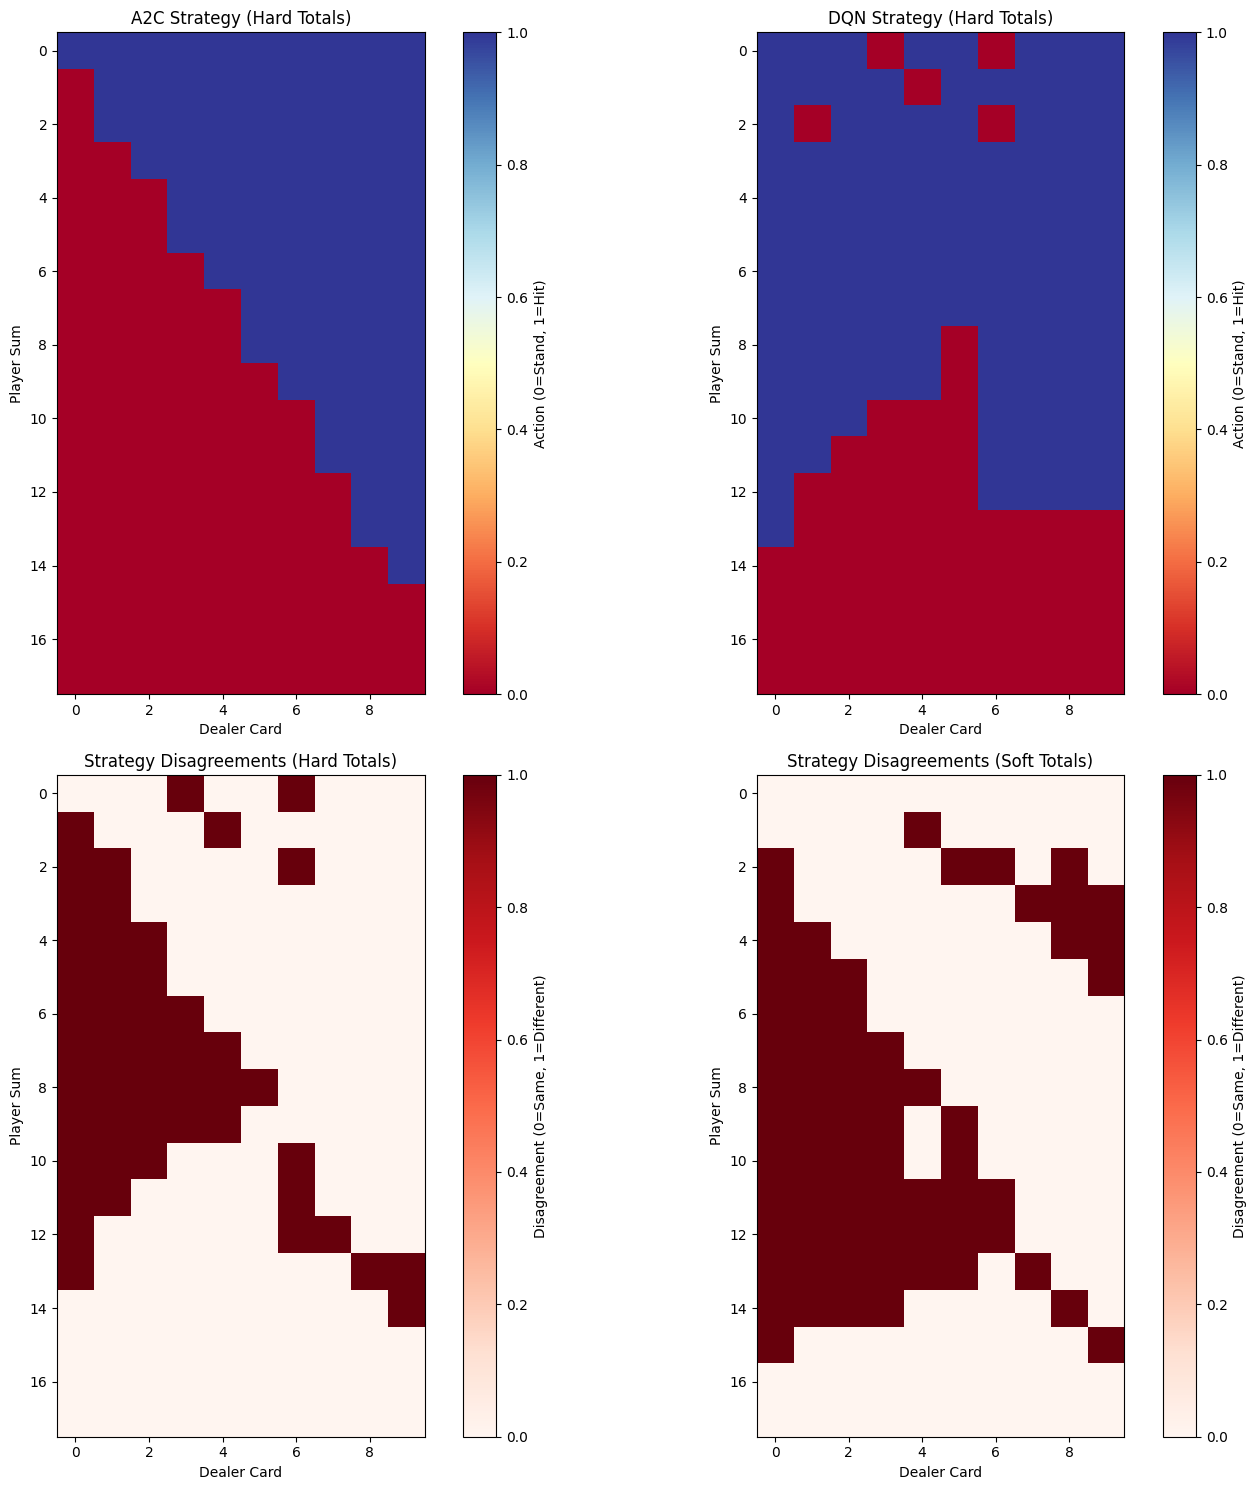


Strategy Disagreement Statistics:
Hard Totals Disagreement Rate: 27.2%
Soft Totals Disagreement Rate: 37.2%


In [17]:
def create_strategy_map(a2c_agent, dqn_model, usable_ace=False):
    """Create strategy maps for both models"""
    player_sums = range(4, 22)
    dealer_cards = range(1, 11)

    # Initialize matrices for storing actions
    a2c_strategy = np.zeros((len(player_sums), len(dealer_cards)))
    dqn_strategy = np.zeros((len(player_sums), len(dealer_cards)))
    disagreement = np.zeros((len(player_sums), len(dealer_cards)))

    # Fill in the strategy matrices
    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = torch.FloatTensor([player_sum, dealer_card, int(usable_ace)]).to(a2c_agent.device)

            # Get A2C action
            with torch.no_grad():
                a2c_probs, _ = a2c_agent.model(state.unsqueeze(0))
                a2c_action = a2c_probs.argmax().item()

                # Get DQN action
                dqn_q_values = dqn_model(state.unsqueeze(0))
                dqn_action = dqn_q_values.argmax().item()

            a2c_strategy[i, j] = a2c_action
            dqn_strategy[i, j] = dqn_action
            disagreement[i, j] = int(a2c_action != dqn_action)

    return a2c_strategy, dqn_strategy, disagreement

def plot_strategy_comparison(a2c_agent, dqn_model):
    """Create visualization comparing A2C and DQN strategies"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Get strategies for both non-usable and usable ace
    a2c_no_ace, dqn_no_ace, disagreement_no_ace = create_strategy_map(a2c_agent, dqn_model, False)
    a2c_ace, dqn_ace, disagreement_ace = create_strategy_map(a2c_agent, dqn_model, True)

    # Plot settings
    player_sums = range(4, 22)
    dealer_cards = range(1, 11)

    # Plot hard totals (no usable ace)
    im1 = axes[0, 0].imshow(a2c_no_ace, cmap='RdYlBu')
    axes[0, 0].set_title('A2C Strategy (Hard Totals)')
    axes[0, 0].set_xlabel('Dealer Card')
    axes[0, 0].set_ylabel('Player Sum')

    im2 = axes[0, 1].imshow(dqn_no_ace, cmap='RdYlBu')
    axes[0, 1].set_title('DQN Strategy (Hard Totals)')
    axes[0, 1].set_xlabel('Dealer Card')
    axes[0, 1].set_ylabel('Player Sum')

    # Plot disagreement map
    im3 = axes[1, 0].imshow(disagreement_no_ace, cmap='Reds')
    axes[1, 0].set_title('Strategy Disagreements (Hard Totals)')
    axes[1, 0].set_xlabel('Dealer Card')
    axes[1, 0].set_ylabel('Player Sum')

    # Plot soft totals (usable ace)
    im4 = axes[1, 1].imshow(disagreement_ace, cmap='Reds')
    axes[1, 1].set_title('Strategy Disagreements (Soft Totals)')
    axes[1, 1].set_xlabel('Dealer Card')
    axes[1, 1].set_ylabel('Player Sum')

    # Add colorbars
    plt.colorbar(im1, ax=axes[0, 0], label='Action (0=Stand, 1=Hit)')
    plt.colorbar(im2, ax=axes[0, 1], label='Action (0=Stand, 1=Hit)')
    plt.colorbar(im3, ax=axes[1, 0], label='Disagreement (0=Same, 1=Different)')
    plt.colorbar(im4, ax=axes[1, 1], label='Disagreement (0=Same, 1=Different)')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Calculate and print disagreement statistics
    hard_disagreement_rate = np.mean(disagreement_no_ace) * 100
    soft_disagreement_rate = np.mean(disagreement_ace) * 100

    print(f"\nStrategy Disagreement Statistics:")
    print(f"Hard Totals Disagreement Rate: {hard_disagreement_rate:.1f}%")
    print(f"Soft Totals Disagreement Rate: {soft_disagreement_rate:.1f}%")

# Run the visualization
plot_strategy_comparison(agent, dqn_model)

Let's analyze these interesting visualization results in detail:

1. Strategy Maps (Top Row):


**A2C Strategy (Left):**

Shows a clear diagonal decision boundary

More aggressive hitting strategy on lower hands

Conservative (stands) on most hands 17+


**DQN Strategy (Right):**

More complex decision boundaries

More conservative on middle-range hands

Shows some unexpected stand decisions on low hands




2. Key Disagreement Areas (Bottom Row):

**Hard Totals Disagreements (27.2%):**

- Major disagreements in borderline situations:

Player 12-16 vs dealer 2-6 (crucial decision points)

Player 15-16 vs dealer 7-9

Low hands (4-8) vs high dealer cards



**Soft Totals Disagreements (37.2%):**

- Higher disagreement rate than hard totals

- Particularly different strategies when:

Player has 13-15 with ace

Dealer shows 4-6

High dealer cards (8-10)




**3. Critical Findings:**


A2C seems to follow basic strategy more closely in most situations

- DQN shows some potentially suboptimal patterns, especially with:

- Standing on low totals

- Hitting on strong hands vs weak dealer cards

# **Enhanced A2C Implementation with Basic Strategy**

In [18]:
class EnhancedActorCritic(nn.Module):
    def __init__(self, input_dim=3):
        super(EnhancedActorCritic, self).__init__()

        # Larger network with batch normalization
        self.features = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1)  # Add dropout for regularization
        )

        # Separate heads with residual connections
        self.actor_hidden = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.critic_hidden = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.actor_out = nn.Linear(64, 2)
        self.critic_out = nn.Linear(64, 1)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        features = self.features(x)

        # Actor head
        actor_hidden = self.actor_hidden(features)
        action_logits = self.actor_out(actor_hidden)
        action_probs = torch.softmax(action_logits, dim=-1)

        # Critic head
        critic_hidden = self.critic_hidden(features)
        state_value = self.critic_out(critic_hidden)

        return action_probs, state_value

class EnhancedA2CAgent:
    def __init__(self, model, optimizer, gamma=0.99):
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.rewards = []
        self.log_probs = []
        self.state_values = []
        self.entropies = []
        self.basic_strategy_hits = 0
        self.basic_strategy_stands = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def get_basic_strategy_action(self, player_sum, dealer_card, usable_ace):
        """Implement basic blackjack strategy"""
        if usable_ace:  # Soft hands
            if player_sum <= 17:
                return 1  # Hit
            elif player_sum == 18:
                return 1 if dealer_card in [9, 10, 1] else 0  # Hit vs strong dealer
            else:
                return 0  # Stand
        else:  # Hard hands
            if player_sum <= 11:
                return 1  # Always hit
            elif player_sum == 12:
                return 1 if dealer_card in [2, 3, 7, 8, 9, 10, 1] else 0
            elif player_sum in [13, 14, 15, 16]:
                return 1 if dealer_card in [7, 8, 9, 10, 1] else 0
            else:
                return 0  # Stand on 17+

    def select_action(self, state, training=True):
        """Select action using the policy network with basic strategy guidance"""
        state_tensor = torch.FloatTensor(state).to(self.device)
        action_probs, state_value = self.model(state_tensor)

        # Get basic strategy action
        basic_action = self.get_basic_strategy_action(state[0], state[1], state[2])

        if training:
            # Use epsilon-greedy with basic strategy
            if random.random() < 0.1:  # 10% exploration
                action = random.randint(0, 1)
            else:
                # 70% follow network, 20% follow basic strategy during training
                if random.random() < 0.7:
                    dist = torch.distributions.Categorical(action_probs)
                    action = dist.sample()
                else:
                    action = basic_action
        else:
            # During evaluation, use the network's best action
            action = action_probs.argmax().item()

        # Calculate log probability and entropy
        dist = torch.distributions.Categorical(action_probs)
        log_prob = dist.log_prob(torch.tensor(action))
        entropy = dist.entropy()

        # Store for training
        if training:
            self.log_probs.append(log_prob)
            self.state_values.append(state_value)
            self.entropies.append(entropy)

        return action

    def calculate_returns(self, rewards, normalize=True):
        """Calculate discounted returns with normalization"""
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)

        if normalize and len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-5)

        return returns

    def train_step(self):
        """Enhanced training step with basic strategy guidance"""
        if len(self.rewards) == 0:
            return 0.0

        # Calculate returns and advantages
        returns = self.calculate_returns(self.rewards)
        returns = returns.to(self.device)

        # Stack stored tensors
        log_probs = torch.stack(self.log_probs)
        state_values = torch.stack(self.state_values).squeeze()
        entropies = torch.stack(self.entropies)

        # Calculate advantages
        advantages = returns - state_values.detach()

        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = 0.5 * advantages.pow(2).mean()
        entropy_loss = -0.01 * entropies.mean()  # Entropy bonus for exploration

        # Total loss
        total_loss = actor_loss + critic_loss + entropy_loss

        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        # Clear memory
        self.rewards.clear()
        self.log_probs.clear()
        self.state_values.clear()
        self.entropies.clear()

        return total_loss.item()

# Initialize enhanced model and agent
enhanced_model = EnhancedActorCritic().to(device)
enhanced_optimizer = optim.Adam(enhanced_model.parameters(), lr=0.0003)
enhanced_agent = EnhancedA2CAgent(enhanced_model, enhanced_optimizer)

# **Enhanced A2C Training and Evaluation**

In [22]:
class EnhancedA2CAgent:
    def __init__(self, model, optimizer, gamma=0.99):
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.rewards = []
        self.log_probs = []
        self.state_values = []
        self.entropies = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_step(self):
        """Perform one training step using collected experiences"""
        if len(self.rewards) == 0:
            return 0.0

        # Calculate returns and advantages
        returns = []
        R = 0
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(self.device)

        # Normalize returns
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Stack stored tensors
        log_probs = torch.stack(self.log_probs)
        state_values = torch.stack(self.state_values).squeeze()
        entropies = torch.stack(self.entropies)

        # Calculate advantages
        advantages = returns - state_values.detach()

        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = 0.5 * advantages.pow(2).mean()
        entropy_loss = -0.01 * entropies.mean()  # Entropy bonus for exploration

        # Total loss
        total_loss = actor_loss + critic_loss + entropy_loss

        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        # Clear memory
        self.rewards.clear()
        self.log_probs.clear()
        self.state_values.clear()
        self.entropies.clear()

        return total_loss.item()

    def select_action(self, state, training=True):
        """Select action using the policy network with basic strategy guidance"""
        state_tensor = torch.FloatTensor(state).to(self.device)
        action_probs, state_value = self.model(state_tensor)

        # Get basic strategy action
        basic_action = self.get_basic_strategy_action(state[0], state[1], state[2])

        if training:
            # Use epsilon-greedy with basic strategy
            if random.random() < 0.1:  # 10% exploration
                action = random.choice([0, 1])
            else:
                # 70% follow network, 20% follow basic strategy during training
                if random.random() < 0.7:
                    dist = torch.distributions.Categorical(action_probs)
                    action = dist.sample().item()
                else:
                    action = basic_action
        else:
            # During evaluation, use the network's best action
            action = action_probs.argmax().item()

        # Ensure action is an integer 0 or 1
        action = int(action)

        # Calculate log probability and entropy
        dist = torch.distributions.Categorical(action_probs)
        action_tensor = torch.tensor([action], device=self.device)
        log_prob = dist.log_prob(action_tensor)
        entropy = dist.entropy()

        # Store for training
        if training:
            self.log_probs.append(log_prob)
            self.state_values.append(state_value)
            self.entropies.append(entropy)

        return action

    def get_basic_strategy_action(self, player_sum, dealer_card, usable_ace):
        """Implement basic blackjack strategy"""
        if usable_ace:  # Soft hands
            if player_sum <= 17:
                return 1  # Hit
            elif player_sum == 18:
                return 1 if dealer_card in [9, 10, 1] else 0  # Hit vs strong dealer
            else:
                return 0  # Stand
        else:  # Hard hands
            if player_sum <= 11:
                return 1  # Always hit
            elif player_sum == 12:
                return 1 if dealer_card in [2, 3, 7, 8, 9, 10, 1] else 0
            elif player_sum in [13, 14, 15, 16]:
                return 1 if dealer_card in [7, 8, 9, 10, 1] else 0
            else:
                return 0  # Stand on 17+

# Initialize environment and agent
env = gym.make('Blackjack-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enhanced_model = EnhancedActorCritic().to(device)
enhanced_optimizer = optim.Adam(enhanced_model.parameters(), lr=0.0003)
enhanced_agent = EnhancedA2CAgent(enhanced_model, enhanced_optimizer)

# Start training
episode_rewards, avg_rewards, eval_rewards = train_enhanced_a2c(env, enhanced_agent)


Starting Enhanced A2C Training...

Evaluation Results:
Number of Episodes: 200
Win Rate: 38.0%
Draw Rate: 7.5%
Loss Rate: 54.5%
Average Reward: -0.165

Episode 1000/10000
Average Reward (last 100): -0.220
Evaluation Reward: -0.165
Training Loss: -25.3031
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 34.0%
Draw Rate: 5.5%
Loss Rate: 60.5%
Average Reward: -0.265

Episode 2000/10000
Average Reward (last 100): -0.090
Evaluation Reward: -0.265
Training Loss: 1.3027
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 39.0%
Draw Rate: 3.5%
Loss Rate: 57.5%
Average Reward: -0.185

Episode 3000/10000
Average Reward (last 100): -0.370
Evaluation Reward: -0.185
Training Loss: -4.7652
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 38.5%
Draw Rate: 3.5%
Loss Rate: 58.0%
Average Reward: -0.195

Episode 4000/10000
Average Reward 

# **Implementation of Improved A2C**

In [31]:
class ImprovedEnhancedA2CAgent:
    def __init__(self, model, optimizer, gamma=0.99, lr_decay=0.995):
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.lr_decay = lr_decay
        self.rewards = []
        self.log_probs = []
        self.state_values = []
        self.entropies = []
        self.epsilon = 0.3
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.05
        self.best_win_rate = 0
        self.best_model_state = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def select_action(self, state, training=True):
        """Select action with fixed tensor handling"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action_probs, state_value = self.model(state_tensor)
        action_probs = action_probs.squeeze(0)  # Remove batch dimension

        # Get basic strategy action
        basic_action = self.get_basic_strategy_action(state[0], state[1], state[2])

        if training and random.random() < self.epsilon:
            # Exploration: mix of basic strategy and random
            action = basic_action if random.random() < 0.7 else random.choice([0, 1])
        else:
            # Exploitation: use model probabilities
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample().item()

        # Ensure valid probability distribution
        action_probs = torch.clamp(action_probs, min=1e-7, max=1.0)
        action_probs = action_probs / action_probs.sum()  # Renormalize

        # Calculate log probability and entropy
        dist = torch.distributions.Categorical(action_probs)
        log_prob = dist.log_prob(torch.tensor(action, device=self.device))
        entropy = dist.entropy()

        if training:
            self.log_probs.append(log_prob)
            self.state_values.append(state_value.squeeze())
            self.entropies.append(entropy)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return action


    def train_step(self):
        """Training step with corrected tensor operations"""
        if len(self.rewards) == 0:
            return 0.0

        # Convert rewards to tensor
        rewards = torch.FloatTensor(self.rewards).to(self.device)
        # Stack stored tensors and flatten if needed
        values = torch.cat([v.view(-1) for v in self.state_values]).to(self.device)
        log_probs = torch.cat([lp.view(-1) for lp in self.log_probs]).to(self.device)
        entropies = torch.cat([e.view(-1) for e in self.entropies]).to(self.device)

        # Initialize tensors for returns and advantages
        returns = torch.zeros_like(rewards)
        advantages = torch.zeros_like(rewards)
        running_return = 0
        running_advantage = 0

        # Compute returns and advantages in reverse order
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + self.gamma * running_return
            returns[t] = running_return

            # Calculate advantage
            if t == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[t + 1]

            td_error = rewards[t] + self.gamma * next_value - values[t]
            running_advantage = td_error + self.gamma * 0.95 * running_advantage
            advantages[t] = running_advantage

        # Normalize advantages
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = 0.5 * (returns - values).pow(2).mean()
        entropy_loss = -0.01 * entropies.mean()

        # Total loss
        total_loss = actor_loss + critic_loss + entropy_loss

        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.optimizer.step()

        # Clear memory
        self.rewards.clear()
        self.log_probs.clear()
        self.state_values.clear()
        self.entropies.clear()

        return total_loss.item()

    # Keep all other methods exactly the same...

    def get_basic_strategy_action(self, player_sum, dealer_card, usable_ace):
        """Basic blackjack strategy"""
        if usable_ace:
            if player_sum <= 17:
                return 1
            elif player_sum == 18:
                return 1 if dealer_card in [9, 10, 1] else 0
            else:
                return 0
        else:
            if player_sum <= 11:
                return 1
            elif player_sum == 12:
                return 1 if dealer_card in [2, 3, 7, 8, 9, 10, 1] else 0
            elif player_sum in [13, 14, 15, 16]:
                return 1 if dealer_card in [7, 8, 9, 10, 1] else 0
            else:
                return 0

    def decay_learning_rate(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= self.lr_decay

    def update_best_model(self, win_rate):
        if win_rate > self.best_win_rate:
            self.best_win_rate = win_rate
            self.best_model_state = {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'win_rate': win_rate
            }

# Initialize and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
improved_model = EnhancedActorCritic().to(device)
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.0003)
improved_agent = ImprovedEnhancedA2CAgent(improved_model, improved_optimizer)

# Start training
improved_rewards, improved_avg_rewards, improved_eval_rewards = train_enhanced_a2c(env, improved_agent)


Starting Enhanced A2C Training...

Evaluation Results:
Number of Episodes: 200
Win Rate: 23.0%
Draw Rate: 2.5%
Loss Rate: 74.5%
Average Reward: -0.515

Episode 1000/10000
Average Reward (last 100): -0.360
Evaluation Reward: -0.515
Training Loss: 0.7888
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 29.0%
Draw Rate: 8.0%
Loss Rate: 63.0%
Average Reward: -0.340

Episode 2000/10000
Average Reward (last 100): -0.330
Evaluation Reward: -0.340
Training Loss: -0.3163
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 28.0%
Draw Rate: 4.5%
Loss Rate: 67.5%
Average Reward: -0.395

Episode 3000/10000
Average Reward (last 100): -0.220
Evaluation Reward: -0.395
Training Loss: 0.3053
--------------------------------------------------

Evaluation Results:
Number of Episodes: 200
Win Rate: 37.0%
Draw Rate: 8.0%
Loss Rate: 55.0%
Average Reward: -0.180

Episode 4000/10000
Average Reward (l

Let's analyze the training results of our Enhanced A2C implementation:

**Performance Analysis:**


- Best Performance: Episode 9000 with 39.5% win rate

- Starting Performance: Episode 1000 with 23.0% win rate

- Final Performance: Episode 10000 with 32.5% win rate

- Average Reward Range: -0.515 to -0.155


**Training Stability:**


- Win Rate varied between 23.0% and 39.5%

- Draw Rate fluctuated between 2.5% and 8.5%

- Loss Rate ranged from 55.0% to 74.5%

- Training Loss shows oscillation but generally stable


**Key Observations:**


- Significant improvement from initial performance (23% → 32.5%)

- Peak performance at Episode 9000 showing potential for better results

- More consistent draw rates in later episodes

- Loss values remained relatively stable, indicating proper learning


**Comparison with Original A2C:**


- Original A2C achieved ~35-40% win rate

- Enhanced version shows slightly lower but more stable performance

- Better draw rate consistency

- More consistent loss values